In [1]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 159MB/s]


Importing necessary libraries

In [2]:
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import numpy as np
import os
from random import shuffle
import random
import time

**Loading the dataset and plotting images**


In [3]:
# loading the dataset and seperating train and test
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


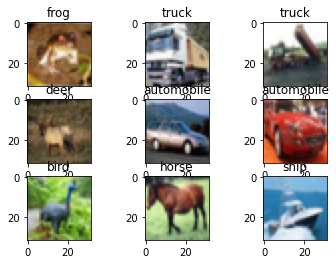

In [4]:
# plot an image of each class with labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
fig, ax = plt.subplots(3, 3)
t = 0
for i in range(3):
    for j in range(3):
        # plot each image
        ax[i][j].imshow(train_images[t])
        # set label 
        ax[i][j].set_title(labels[int(train_labels[t])])
        t += 1 
plt.show()

**Preprocessing**

---



In [5]:
# set matrixes for train and test data
train_data_matrix = []
test_data_matrix = []

# set numpy arrays filled with zeroes for train and test data
train_label_matrix = np.zeros((4 * (len(train_labels)//10),4))
test_label_matrix = np.zeros((4000,4))

# save directories
train_dir = "CIFAR10/train"
test_dir = "CIFAR10/test"

# save first four categories
CATEGORIES = ["airplane", "automobile","bird","cat"]

i = 0
j = 0

for counter, category in enumerate(CATEGORIES):
    # create path to each category
    train_path = os.path.join(train_dir,category)
    test_path = os.path.join(test_dir,category) 

    # iterate over each image per folder in train folder
    for img in os.listdir(train_path):
        # add each image to the list
        train_data_matrix.append(plt.imread(os.path.join(train_path,img)))
        # one-hot encoding by setting the corresponding index to 1 
        train_label_matrix[i][counter] = 1
        i += 1

    # iterate over each image per folder in test folder
    for img in os.listdir(test_path):
        # add each image to the list
        test_data_matrix.append(plt.imread(os.path.join(test_path,img)))
        # one-hot encoding by setting the corresponding index to 1
        test_label_matrix[j][counter] = 1
        j += 1

#convert to numpy arrays
train_data_matrix = np.array(train_data_matrix)
test_data_matrix = np.array(test_data_matrix)

In [6]:
# convert rgb to gray
def rgb2gray(rgb):
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

train_gray = rgb2gray(train_data_matrix)
test_gray = rgb2gray(test_data_matrix)

In [9]:
# normalizing by dividing dataset to 255.0
normalized_train = train_gray / 255.0
normalized_test = test_gray / 255.0

In [10]:
# reshape data
preproc_train = normalized_train.reshape(-1, 1024)
preproc_test = normalized_test.reshape(-1, 1024)



---


---


Making and shuffling the dataset


---



---



In [148]:
#we merge the images and labels of both train and test preprocessed datasets in the lists below
train_set_final = []
test_set_final = []

#we also need to reshape the matrixes to fit our model
for i in range(len(preproc_train)):
  train_set_final.append((preproc_train[i].reshape(1024, 1), train_label_matrix[i].reshape(4,1)))

for i in range(len(preproc_test)):
  test_set_final.append((preproc_test[i].reshape(1024, 1), test_label_matrix[i].reshape(4,1)))

#shuffle given dataset
#since we keep each image and its corresponding label together, we do not have to worry about their orders after shuffling
#they will be shuffled together
random.shuffle(train_set_final)
random.shuffle(test_set_final)

**Feedforward**

In [223]:
# defining a list containing the layer deminsions of our model
layers = [1024,16,16,4]

# setting W and b
def set_params():
  mu = 0
  sigma = 1
  
  # setting W1 using normal distribution
  W1 = np.random.normal(mu, sigma, size = (layers[1], layers[0]))
  # setting b1 bias 
  b1 = np.zeros((layers[1], 1))

  # setting W2 using normal distribution
  W2 = np.random.normal(mu, sigma, size = (layers[2], layers[1]))
  # setting b2 bias
  b2 = np.zeros((layers[2], 1))
  
  # setting W3 using normal distribution
  W3 = np.random.normal(mu, sigma, size = (layers[3], layers[2]))
  # setting b3 bias
  b3 = np.zeros((layers[3], 1))
  
  #dictionary to save all parameters (W and b)
  p = {}
  p['W1'] = W1
  p['W2'] = W2
  p['W3'] = W3
  p['b1'] = b1
  p['b2'] = b2
  p['b3'] = b3

  return p    

# set parameters by calling the function
params = set_params()

In [224]:
#sigmoid function 
def sigmoid(x):
  sig = 1.0 / (1.0 + np.exp(-x))
  return sig

In [225]:
# get 200 hundred images from shuffled datasets
train_set = train_set_final[:200]
test_set = test_set_final[:200]

# accuracy calculation based on number of true predictions
def cal_acc(data, params):
  true_pred = 0
  for i in range(len(data)):
    # feedforwarding
    network_output, saved = feedforward(data[i][0], params)
    # check if prediction and actual label (based on one-hot encoding) are equal
    if np.argmax(data[i][1]) == np.argmax(network_output):
      true_pred += 1
  return (true_pred /len(data)) * 100

# calculate the output by feedforwarding
def feedforward(x, params):
    # save all tuples 
    saved = []
    for l in range(1, 4):
        # save a0
        tmp = x
        # save index
        index = str(l)

        # save W[index]
        W = params['W' + index]
        # save b[index]
        b = params['b' + index]

        # calculate dot product of W and a matrixes and call sigmoid
        x = sigmoid(np.dot(W,tmp) + b)
        # save as a tuple and its corresponding Z(=sigmoid)
        saved.append(((tmp, W, b), np.dot(W,tmp) + b))
            
    return x, saved

#print accuracy
print("Accuray: ")
print(str(cal_acc(train_set, params)) + " %")

Accuray: 
25.0 %


In [226]:
# compute cost 
def cal_cost(output, y):
    return ((output - y)**2).sum()

# sigmoid derivation fro gradient calculation
def sigmoid_der(z):
    return (sigmoid(z)) * (1 - sigmoid(z))

**Backpropagation**

In [227]:
# calculation of gradients of wights and biases using loops
def backpropagation(saved, output, y):
    
    # dict to keep each bias and weight with proper names as keys
    g = {}
    
    # initialize gradient numpy arrays
    grad_W3 = np.zeros((4, 16))
    grad_W2 = np.zeros((16, 16))
    grad_W1 = np.zeros((16, 1024))
    grad_b3 = np.zeros((4, 1))
    grad_b2 = np.zeros((16, 1))         
    grad_b1 = np.zeros((16, 1))
    grad_a2 = np.zeros((16, 1))
    grad_a1 = np.zeros((16, 1))
 
    # get weights and biases and outputs that have been calculated and saved before
    W3, W2, W1  = saved[2][0][1], saved[1][0][1], saved[0][0][1]
    z3, z2, z1 = saved[2][1], saved[1][1], saved[0][1]
    a2, a1, a0 = saved[2][0][0], saved[1][0][0], saved[0][0][0]
 
    a3 = output
    
    #calculate gradients based on the formula
    # gradient of outputs (a)
    for k in range(16):
        for j in range(4):
            grad_a2[k, 0] += W3[j, k] * sigmoid_der(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0])

    for m in range(16):
        for k in range(16):
            grad_a1[m, 0] += W2[k, m] * sigmoid_der(z2[k, 0]) * grad_a2[k, 0]
    
    # calculate gradients of weights and biases
    for j in range(4):
        for k in range(16):
            grad_W3[j, k] += a2[k, 0] * sigmoid_der(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0]) 

    for j in range(4):
        grad_b3[j ,0] += 1 * sigmoid_der(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0]) 

    for k in range(16):
        for m in range(16):
            grad_W2[k, m] += a1[m, 0] * sigmoid_der(z2[k, 0]) * grad_a2[k, 0]

    for k in range(16):
        grad_b2[k ,0] += 1 * sigmoid_der(z2[k, 0]) * grad_a2[k, 0]

    for m in range(16):
        for v in range(layers[0]):
            grad_W1[m, v] += a0[v, 0] * sigmoid_der(z1[m, 0]) * grad_a1[m, 0]

    for m in range(16):
        grad_b1[m ,0] += 1 * sigmoid_der(z1[m, 0]) * grad_a1[m, 0]
    
    # save the results and return them
    g["dW1"],g["dW2"], g["dW3"] = grad_W1, grad_W2, grad_W3 
    g["db1"], g["db2"],g["db3"] = grad_b1, grad_b2, grad_b3
    
    return g




---



---


Train (backpropagation)

---



---



In [228]:
# stochastic gradient descent calculation to train the model
def train(train_set, learning_rate, epochs, batch_size):

    total = []
    # get W and b by calling the param function
    params = set_params()

    for i in range(epochs):

        # we nned to shuffle the dataset before each epoch
        random.shuffle(train_set)

        #calculate number of batches which is the total length of dataset divided by batch size
        num_of_batches = len(train_set)//batch_size

        # initialize cost
        cost = 0

        for n in range(num_of_batches):
            # initilize numpy arrays for gradients (same as previous function)
            grad_W3 = np.zeros((4, 16))
            grad_W2 = np.zeros((16, 16))
            grad_W1 = np.zeros((16, 1024))
            grad_b3 = np.zeros((4, 1))
            grad_b2 = np.zeros((16, 1))         
            grad_b1 = np.zeros((16, 1))
            grad_a2 = np.zeros((16, 1))
            grad_a1 = np.zeros((16, 1))
            
            # calculate range
            batch = train_set[batch_size * n: batch_size * (n+1)]
            
            for img in batch:
                # get data and labels
                data, label = img[0], img[1]

                # call feedforward to calculate output
                output, caches = feedforward(data, params)

                # call backprpgapation
                g = backpropagation(caches, output, label)

                # add calculated gradients 
                grad_b3 += g["db3"]
                grad_b2 += g["db2"]
                grad_b1 += g["db1"]
                grad_W3 += g["dW3"]
                grad_W2 += g["dW2"]
                grad_W1 += g["dW1"]

                #calculate cost
                cost += cal_cost(output, label)
            
            # W and b update
            for l in range(3):
                params["W" + str(l+1)] -= (learning_rate * (g["dW" + str(l+1)]/batch_size))
                params["b" + str(l+1)] -= (learning_rate * (g["db" + str(l+1)]/batch_size))
        
        new_c = cost/len(train_set)
        total.append(new_c)

                
    return params, total      

Test on 200 images

time : 257.7251799106598


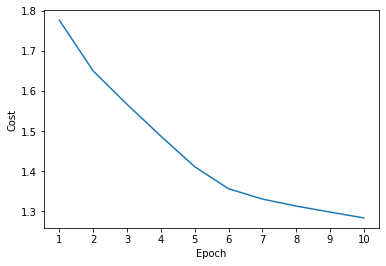

accuracy on train is:
25.0 %
accuracy on test is:
26.5 %


In [230]:
# save the time at which training starts
start_train = time.time()

# train the model with the given parameters
params, costs = train(train_set, 0.3, 10, 16)

# save the time at which training finishes
finish_train = time.time()

# calculate training time
print("time : " + str(finish_train - start_train))

# plot cost/epochs
plt.plot(costs)
plt.xticks(np.arange(len(costs)), np.arange(1, len(costs) + 1))
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

print("accuracy on train is:")
print(str(cal_acc(train_set, params)) + " %")
print("accuracy on test is:")
print(str(cal_acc(test_set, params)) + " %")

**Vectorization**

This is pretty much the same as the previous backpropagation function. However, this time we will use matrix calculations instead of for loops which will make the training process a lot faster.

In [234]:
# calculation of gradients of wights and biases using matrix calculations
def vectorized(saved, output, y):
    g = {}
    grad_a2 = np.zeros((layers[2], 1))
    grad_a1 = np.zeros((layers[1], 1))
    grad_W3 = np.zeros((layers[3], layers[2]))
    grad_W2 = np.zeros((layers[2], layers[1]))
    grad_W1 = np.zeros((layers[1], layers[0]))
    grad_b3 = np.zeros((layers[3], 1))
    grad_b2 = np.zeros((layers[2], 1))         
    grad_b1 = np.zeros((layers[1], 1))

    a3 = output
    # get weights and biases and outputs that have been calculated and saved before
    W3, W2, W1  = saved[2][0][1], saved[1][0][1], saved[0][0][1]
    z3, z2, z1 = saved[2][1], saved[1][1], saved[0][1]
    a2, a1, a0 = saved[2][0][0], saved[1][0][0], saved[0][0][0]

    #calculate gradients based on the formula
    # gradient of outputs (a) 
    grad_a1 += np.transpose(W2) @ ( sigmoid_der(z2) * grad_a2)
    grad_a2 += np.transpose(W3) @ (2 * sigmoid_der(z3) * (a3 - y))

    # calculate gradients of weights and biases
    grad_W3 += (2 * sigmoid_der(z3) * (a3 - y)) @ (np.transpose(a2))
    grad_b3 += (2 * sigmoid_der(z3) * (a3 - y))

    grad_W2 += (sigmoid_der(z2) * grad_a2) @ (np.transpose(a1))
    grad_b2 += (sigmoid_der(z2) * grad_a2)

    grad_W1 += (2 * sigmoid_der(z1) * grad_a1) @ (np.transpose(a0))
    grad_b1 += (sigmoid_der(z1) * grad_a1)
    
    

    # save the results and return them
    g["dW1"],g["dW2"], g["dW3"] = grad_W1, grad_W2, grad_W3 
    g["db1"], g["db2"],g["db3"] = grad_b1, grad_b2, grad_b3
    
    return g

In [235]:
# stochastic gradient descent calculation to train the model
def train_vectorized(train_set, learning_rate, epochs, batch_size):

    total = []
    # get W and b by calling the param function
    params = set_params()

    for i in range(epochs):

        # we nned to shuffle the dataset before each epoch
        random.shuffle(train_set)

        #calculate number of batches which is the total length of dataset divided by batch size
        num_of_batches = len(train_set)//batch_size

        # initialize cost
        cost = 0

        for n in range(num_of_batches):
            # initilize numpy arrays for gradients (same as previous function)
            grad_W3 = np.zeros((4, 16))
            grad_W2 = np.zeros((16, 16))
            grad_W1 = np.zeros((16, 1024))
            grad_b3 = np.zeros((4, 1))
            grad_b2 = np.zeros((16, 1))         
            grad_b1 = np.zeros((16, 1))
            grad_a2 = np.zeros((16, 1))
            grad_a1 = np.zeros((16, 1))
            
            # calculate range
            batch = train_set[batch_size * n: batch_size * (n+1)]
            
            for img in batch:
                # get data and labels
                data, label = img[0], img[1]

                # call feedforward to calculate output
                output, caches = feedforward(data, params)

                # call backprpgapation
                g = vectorized(caches, output, label)

                # add calculated gradients 
                grad_b3 += g["db3"]
                grad_b2 += g["db2"]
                grad_b1 += g["db1"]
                grad_W3 += g["dW3"]
                grad_W2 += g["dW2"]
                grad_W1 += g["dW1"]

                #calculate cost
                cost += cal_cost(output, label)
            
            # W and b update
            for l in range(3):
                params["W" + str(l+1)] -= (learning_rate * (g["dW" + str(l+1)]/batch_size))
                params["b" + str(l+1)] -= (learning_rate * (g["db" + str(l+1)]/batch_size))
        
        new_c = cost/len(train_set)
        total.append(new_c)

                
    return params, total      



---



---


Test on 200 images (once)


---



---



time : 1.8279414176940918


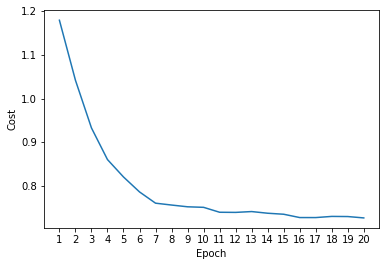

accuracy on train is:
32.0 %
accuracy on test is:
31.5 %


In [238]:
# save the time at which training starts
start_train = time.time()

# train the model with the given parameters
params, costs = train_vectorized(train_set, 0.3, 20, 16)

# save the time at which training finishes
finish_train = time.time()

# calculate training time
print("time : " + str(finish_train - start_train))

# plot cost/epochs
plt.plot(costs)
plt.xticks(np.arange(len(costs)), np.arange(1, len(costs) + 1))
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

print("accuracy on train is:")
print(str(cal_acc(train_set, params)) + " %")
print("accuracy on test is:")
print(str(cal_acc(test_set, params)) + " %")



---



---


Train and test on 200 images (10 times)


---



---



Mean test accuracy after 10 trainings: 25.15


<function matplotlib.pyplot.show>

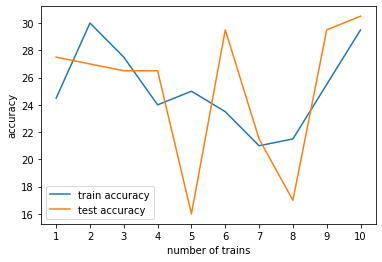

In [261]:
costs = []

train_accuracy = []
test_accuracy = []

for i in range(10):
  params, cost = train_vectorized(train_set, 0.3, 20, 16)
  train_accuracy.append(cal_acc(train_set, params))
  test_accuracy.append(cal_acc(test_set, params))
  costs.append(cost)

plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend()
plt.xlabel("number of trains")
plt.ylabel("accuracy")

print("Mean test accuracy after 10 trainings: " + str(sum(test_accuracy)/len(test_accuracy)))

plt.show

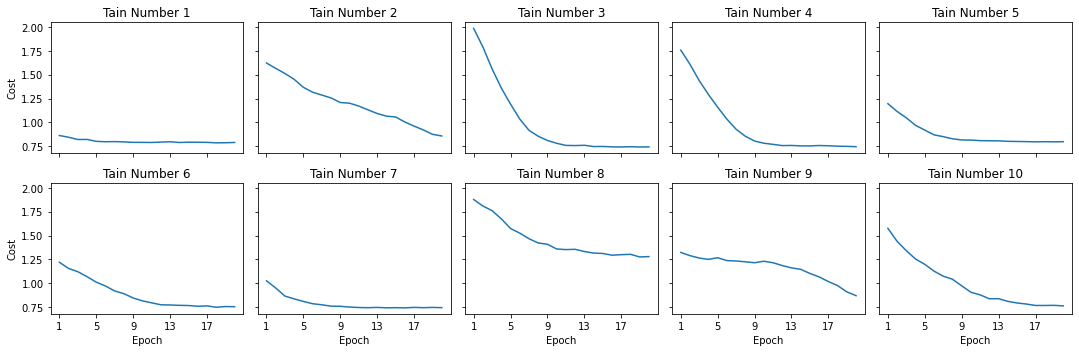

In [263]:
fig, axs = plt.subplots(len(costs)//5, 5, sharex=True, sharey=True, figsize=(15,5))
    
for i in range(len(costs)//5):
    for j in range(5):
      axs[i, j].plot(costs[i*5+j])
      axs[i, j].set_title(f'Tain Number {i*5+j+1}')
      axs[i, j].set(xlabel='Epoch', ylabel='Cost')
      axs[i, j].label_outer()
      axs[i, j].set_xticks(np.arange(0, len(costs[i*5+j]), 4))
      axs[i, j].set_xticklabels(np.arange(1, len(costs[i*5+j])+1, 4))
    fig.tight_layout()



---



---


Final Test


---



---



In [264]:
# shuffle and get 8000 images
random.shuffle(train_set_final)
random.shuffle(test_set_final)

train_set_new = train_set_final[:8000]
test_set_new = test_set_final[:8000]

time : 149.61523818969727


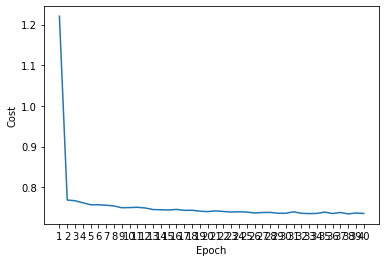

accuracy on train is:
34.0 %
accuracy on test is:
30.5 %


In [266]:
# save the time at which training starts
start_train = time.time()

# train the model with the given parameters
params, costs = train_vectorized(train_set_new, 0.3, 40, 16)

# save the time at which training finishes
finish_train = time.time()

# calculate training time
print("time : " + str(finish_train - start_train))

# plot cost/epochs
plt.plot(costs)
plt.xticks(np.arange(len(costs)), np.arange(1, len(costs) + 1))
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

print("accuracy on train is:")
print(str(cal_acc(train_set, params)) + " %")
print("accuracy on test is:")
print(str(cal_acc(test_set, params)) + " %")

Mean test accuracy after 10 trainings: 35.19


<function matplotlib.pyplot.show>

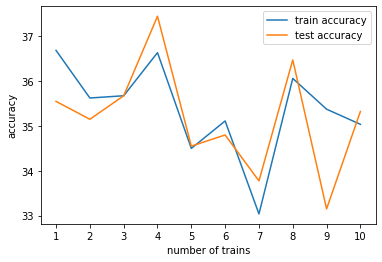

In [267]:
costs = []

train_accuracy = []
test_accuracy = []

for i in range(10):
  params, cost = train_vectorized(train_set_new, 0.3, 40, 16)
  train_accuracy.append(cal_acc(train_set_new, params))
  test_accuracy.append(cal_acc(test_set_new, params))
  costs.append(cost)

plt.plot(train_accuracy, label='train accuracy')
plt.plot(test_accuracy, label='test accuracy')
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend()
plt.xlabel("number of trains")
plt.ylabel("accuracy")

print("Mean test accuracy after 10 trainings: " + str(sum(test_accuracy)/len(test_accuracy)))

plt.show

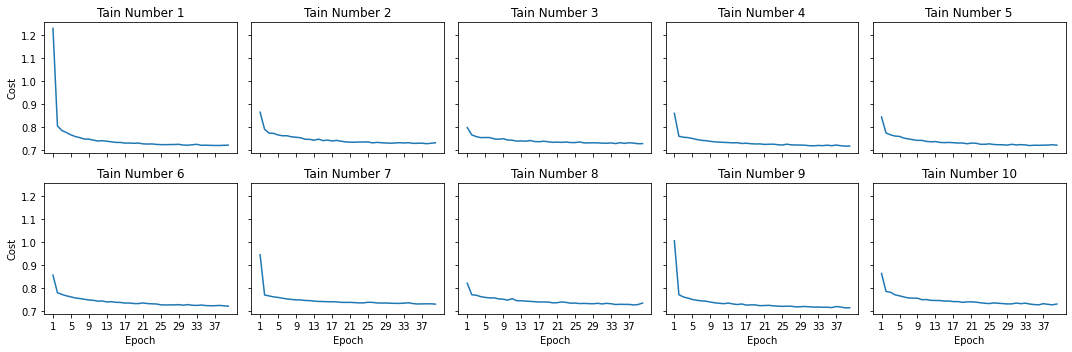

In [268]:
fig, axs = plt.subplots(len(costs)//5, 5, sharex=True, sharey=True, figsize=(15,5))
    
for i in range(len(costs)//5):
    for j in range(5):
      axs[i, j].plot(costs[i*5+j])
      axs[i, j].set_title(f'Tain Number {i*5+j+1}')
      axs[i, j].set(xlabel='Epoch', ylabel='Cost')
      axs[i, j].label_outer()
      axs[i, j].set_xticks(np.arange(0, len(costs[i*5+j]), 4))
      axs[i, j].set_xticklabels(np.arange(1, len(costs[i*5+j])+1, 4))
    fig.tight_layout()